# Controllable Set Problem
This notebook provides an example of the controllable set problem; we solve for the feasible initial state given the terminal state set. This example is shown for Mars landing scenario with flat-planet assumption; constatnt gravity.

In [1]:
import numpy as np
import cvxpy as cp
from tqdm import tqdm
import sys
sys.path.append("../../")
import src.lcvx as lc
from src.visualization import *
%load_ext autoreload
%matplotlib inline

In [11]:
# Simulation configuration
rocket = lc.Rocket(
    g_=3.7114,
    mdry=1505.0,
    mwet=1905.0,
    Isp=225.0,
    rho1=4972.0,
    rho2=13260.0,
    gsa=(90-15/2) * np.pi / 180,
    pa=30 * np.pi / 180,
    vmax=200.0,
)
N = 55
tf = 75.0
dt = tf / N
xf_bounds = (
    np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, np.log(rocket.mdry)]),  # Initial state vector (m, m, m, m/s, m/s, m/s, kg)
    np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, np.log(1750.0)]),  # Initial state vector (m, m, m, m/s, m/s, m/s, kg)
)

In [12]:
# Define the problem
lcvx = lc.LCvxControllability(rocket=rocket, N=N, alt0=1500.0)
directional_cstr=[False, False, False, True, False, True, False]
prob = lcvx.problem(xf_bounds=xf_bounds, tf=tf, xc=np.zeros(7), directional_cstr=directional_cstr)

In [17]:
# Define directional vectors
thetas = np.linspace(0, np.pi, 10)
x_profiles = []
u_profiles = []

for theta in tqdm(thetas):
    # Define directional vector
    c = np.array([0.0, 0.0, 0.0, np.sin(theta), 0.0, -np.cos(theta), 0.0])
    # Handle parameter; set the directional constraint
    lc.set_params(prob, {'c': c})
    # Solve the problem
    prob.solve(solver=cp.ECOS, verbose=False)
    # get solution
    sol = lc.get_vars(prob, ['X', 'U'])
    X_sol = sol['X']
    U_sol = sol['U']
    r, v, z, u, sigma = lcvx.recover_variables(X_sol, U_sol)
    m = np.exp(z)
    X = np.hstack((r.T, v.T, m.reshape(-1, 1)))
    U = u.T * m[:-1].reshape(-1, 1)
    # Store the profiles
    x_profiles.append(X)
    u_profiles.append(U)
t = np.linspace(0, tf, N + 1)

100%|██████████| 10/10 [00:00<00:00, 61.14it/s]


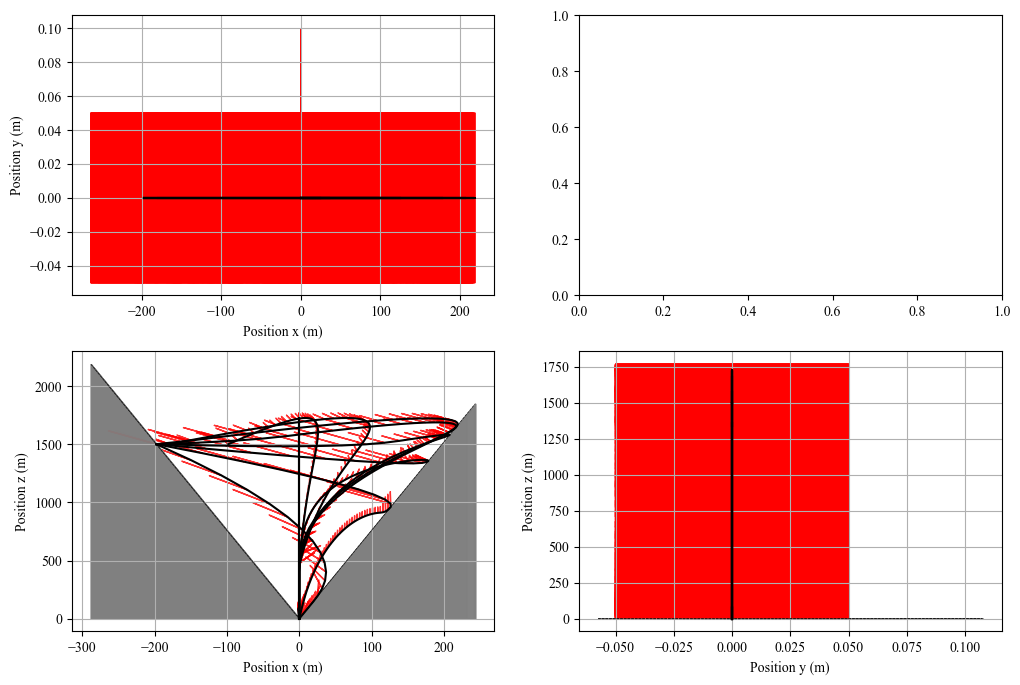

In [18]:
fig, axs = None, None
for i in range(len(thetas)):
    fig, axs = plot_3sides(t[:-1], x_profiles[i], u_profiles[i], uskip=1, gsa=rocket.gsa, fig=fig, axs=axs)

plt.show()